<a href="https://colab.research.google.com/github/trafalgardlaw2406/RANC/blob/main/RANC_supine_serial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import operator
import functools
import math
import os

from scipy import ndimage
import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras import initializers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Flatten, Activation, Input, Lambda, concatenate,Average
from tensorflow.keras.datasets import mnist,fashion_mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from tensorflow.keras import activations
from tensorflow.keras import initializers
from tensorflow.keras import regularizers
from tensorflow.keras import constraints
import sys
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import cv2
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
class Tea(Layer):
    def __init__(self,
                 units,
                 **kwargs):
        """Initializes a new TeaLayer.

        Arguments:
            units -- The number of neurons to use for this layer."""
        self.units = units
        # Needs to be set to `True` to use the `K.in_train_phase` function.
        self.uses_learning_phase = True
        super(Tea, self).__init__(**kwargs)

def tea_weight_initializer(shape, dtype=np.float32):
    """Returns a tensor of alternating 1s and -1s, which is (kind of like)
    how IBM initializes their weight matrix in their TeaLearning
    literature.

    Arguments:
        shape -- The shape of the weights to intialize.

    Keyword Arguments:
        dtype -- The data type to use to initialize the weights.
                 (default: {np.float32})"""
    num_axons = shape[0]
    num_neurons = shape[1]
    ret_array = np.zeros((int(num_axons), int(num_neurons)), dtype=np.float32)
    for axon_num, axon in enumerate(ret_array):
        if axon_num % 2 == 0:
            for i in range(len(axon)):
                ret_array[axon_num][i] = 1
        else:
            for i in range(len(axon)):
                ret_array[axon_num][i] = -1
    return tf.convert_to_tensor(ret_array)

def build(self, input_shape):
    assert len(input_shape) >= 2
    shape = (input_shape[-1], self.units)
    self.static_weights = self.add_weight(
        name='weights',
        shape=shape,
        initializer=tea_weight_initializer,
        trainable=False)
    # Intialize connections around 0.5 because they represent probabilities.
    self.connections = self.add_weight(
        name='connections',
        initializer=initializers.TruncatedNormal(mean=0.5),
        shape=shape)
    self.biases = self.add_weight(
        name='biases',
        initializer='zeros',
        shape=(self.units,))
    super(Tea, self).build(input_shape)

# Bind the method to our class
Tea.build = build

def call(self, x):
    with tf.get_default_graph().gradient_override_map(
        {"Round":"CustomRound"}):
        # Constrain input
        x = tf.round(x)
        # Constrain connections
        connections = self.connections
        connections = tf.round(connections)
        connections = K.clip(connections, 0, 1)
        # Multiply connections with weights
        weighted_connections = connections * self.static_weights
        # Dot input with weighted connections
        output = K.dot(x, weighted_connections)
        # Constrain biases
        biases = tf.round(self.biases)
        output = K.bias_add(
            output,
            biases,
            data_format='channels_last'
        )
        # Apply activation / spike
        output = K.in_train_phase(
            K.sigmoid(output),
            tf.cast(tf.greater_equal(output, 0.0), tf.float32)
        )
    return output
    
# Bind the method to our class
Tea.call = call

def compute_output_shape(self, input_shape):
    assert input_shape and len(input_shape) >= 2
    assert input_shape[-1]
    output_shape = list(input_shape)
    output_shape[-1] = self.units
    return tuple(output_shape)
    
# Bind the method to our class
Tea.compute_output_shape = compute_output_shape


class AdditivePooling(Layer):
    """A helper layer designed to format data for output during TeaLearning.
    If the data input to the layer has multiple spikes per classification, the
    spikes for each tick are summed up. Then, all neurons that correspond to a
    certain class are summed up so that the output is the number of spikes for
    each class. Neurons are assumed to be arranged such that each
    `num_classes` neurons represent a guess for each of the classes. For
    example, if the guesses correspond to number from 0 to 9, the nuerons are
    arranged as such:

        neuron_num: 0  1  2  3  4  5  6  7  8  9  10 11 12  ...
        guess:      0  1  2  3  4  5  6  7  8  9  0  1  2   ..."""

    def __init__(self,
                 num_classes,
                 **kwargs):
        """Initializes a new `AdditivePooling` layer.

        Arguments:
            num_classes -- The number of classes to output.
        """
        self.num_classes = num_classes
        self.num_inputs = None
        super(AdditivePooling, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) >= 2
        # The number of neurons must be collapsable into the number of classes
        assert input_shape[-1] % self.num_classes == 0
        self.num_inputs = input_shape[-1]

    def call(self, x):
        # Sum up ticks if there are ticks
        if len(x.shape) >= 3:
            output = K.sum(x, axis=1)
        else:
            output = x
        # Reshape output
        output = tf.reshape(
            output,
            [-1, int(self.num_inputs // self.num_classes), self.num_classes]
        )
        # Sum up neurons
        output = tf.reduce_sum(output, 1)
        return output

    def compute_output_shape(self, input_shape):
        output_shape = list(input_shape)
        # Last dimension will be number of classes
        output_shape[-1] = self.num_classes
        # Ticks were summed, so delete tick dimension if exists
        if len(output_shape) >= 3:
            del output_shape[1]
        return tuple(output_shape)

In [4]:
# Data Load
import os
import numpy as np

# PyTorch (modeling)
# import torch
# from torch import nn
# import torch.nn.functional as F
# import torch.optim as optim
# from torch.utils.data.sampler import SubsetRandomSampler
# from torchvision import transforms
# import torchvision.transforms.functional as TF
# from torch.utils.data import Dataset
# from torch.utils.data import random_split
# from torch.utils.data import DataLoader

# # Visualization
# import matplotlib.pyplot as plt

import sys
from scipy import ndimage

# These functions are introduced along the Part 1 notebook.

# Position vectors. We load the data with respect to the file name, which is
# a number corresponding to a specific in-bed position. We take advantage of this
# and use the number to get the position with help of the following vectors.

positions_i = ["justAPlaceholder", "supine_1", "right_0",
               "left_0", "right_30", "right_60",
               "left_30", "left_60", "supine_2",
               "supine_3", "supine_4", "supine_5",
               "supine_6", "right_fetus", "left_fetus",
               "supine_30", "supine_45", "supine_60"]

positions_i_short = ["justAPlaceholder", "supine", "right",
               "left", "right", "right",
               "left", "left", "supine",
               "supine", "supine", "supine",
               "supine", "right", "left",
               "supine", "supine", "supine"]

positions_ii = {
    "B":"supine", "1":"supine", "C":"right",
    "D":"left", "E1":"right", "E2":"right",
    "E3":"left", "E4":"left", "E5":"right",
    "E6":"left", "F":"supine", "G1":"supine",
    "G2":"right", "G3":"left"
}

class_positions = ['supine', 'left', 'right', 'left_fetus', 'right_fetus']

# We also want the classes to be encoded as numbers so we can work easier when
# modeling. This function achieves so. Since left_fetus and right_fetus are not
# considered as classes in the evaluation of the original paper and since they
# are not considered in the "Experiment I", we encode them also as left and right
# positions.

def token_position_short(x):
  return {
      'supine': 0,
      'left': 1,
      'right': 2,
      'left_fetus': 1,
      'right_fetus': 2
  }[x]

def token_position(x):
  return {
      "supine_1":0, 
      "right_0":1,
      "left_0":2, 
      "right_30":3, 
      "right_60":4,
      "left_30":5, 
      "left_60":6, 
      "supine_2":7,
      "supine_3":8, 
      "supine_4":9, 
      "supine_5":10,
      "supine_6":11, 
      "right_fetus":12, 
      "left_fetus":13,
      "supine_30":14, 
      "supine_45":15, 
      "supine_60":16
  }[x]

def token_position_new(x):
  return {
      "supine_1":0, 
      "supine_2":1,
      "supine_3":2, 
      "supine_4":3, 
      "supine_5":4,
      "supine_6":5, 
      "supine_30":6, 
      "supine_45":7, 
      "supine_60":8, 
      "left_0":9, 
      "left_30":10, 
      "left_60":11,
      "left_fetus":12, 
      "right_0":13,
      "right_30":14, 
      "right_60":15,
      "right_fetus":16, 
  }[x]
list_supine = ["1.txt","8.txt","9.txt","10.txt","11.txt","12.txt","15.txt","16.txt","17.txt"]

list_supine_norm_1 = ["1.txt","8.txt","9.txt"]

list_supine_norm_2 = ["10.txt","11.txt","12.txt"]

list_supine_incl = ["15.txt","16.txt","17.txt"]

list_left = ["3.txt","6.txt","7.txt","14.txt"]

list_right = ["2.txt","4.txt","5.txt","13.txt"]

def token_position_supine(x):
  return {
      "supine_1":0, 
      "supine_2":1,
      "supine_3":2, 
      "supine_4":3, 
      "supine_5":4,
      "supine_6":5, 
      "supine_30":6, 
      "supine_45":7, 
      "supine_60":8
    }[x]

def token_position_supine_norm_1(x):
  return {
      "supine_1":0, 
      "supine_2":1,
      "supine_3":2, 
    }[x]

def token_position_supine_norm_2(x):
  return {
      "supine_4":0, 
      "supine_5":1,
      "supine_6":2, 
    }[x]

def token_position_supine_incl(x):
  return {
      "supine_30":0, 
      "supine_45":1, 
      "supine_60":2
    }[x]

def token_position_left(x):
  return {
      "left_0":0, 
      "left_30":1, 
      "left_60":2,
      "left_fetus":3,
  }[x]

def token_position_right(x):
  return {
      "right_0":0,
      "right_30":1, 
      "right_60":2,
      "right_fetus":3, 
  }[x]


def load_exp_i(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      max_val = []
      for _, _, files in os.walk(os.path.join(path, directory)):
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            lines = f.read().splitlines()[2:]
            for i in range(3, len(lines) - 3):
                              
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                
                # Spatio-temporal median filter 3x3x3
                raw_data = ndimage.median_filter(raw_data, 3)
                past_image = ndimage.median_filter(past_image, 3)
                future_image = ndimage.median_filter(future_image, 3)
                raw_data = np.concatenate((raw_data[np.newaxis, :, :], past_image[np.newaxis, :, :], future_image[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
            
            # with open(file_path, 'r') as f:
            #   # Start from second recording, as the first two are corrupted
            #   lines = f.read().splitlines()[2:]
            #   for line in f.read().splitlines()[2:]:
            #     # print(line)
            #     raw_data = np.fromstring(line, dtype=float, sep='\t')
                # Change the range from [0-1000] to [0-255].
                  # max_val.append(np.amax(raw_data))
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              # file_data = np.round(raw_data).astype(np.uint8)
              
              file_data = file_data.reshape((1,64,32))
              # print(positions_i[int(file[:-4])])
              file_label = token_position(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)
      
      # max_over_all = max(max_val)
      # print(max_over_all)

      # data = np.round(data * 255/1000).astype(np.uint8)
      dataset[subject] = (data, labels)

  return dataset

def load_exp_i_short(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      max_val = []
      for _, _, files in os.walk(os.path.join(path, directory)):
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            lines = f.read().splitlines()[2:]
            for i in range(3, len(lines) - 3):
                              
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                
                # Spatio-temporal median filter 3x3x3
                raw_data = ndimage.median_filter(raw_data, 3)
                past_image = ndimage.median_filter(past_image, 3)
                future_image = ndimage.median_filter(future_image, 3)
                raw_data = np.concatenate((raw_data[np.newaxis, :, :], past_image[np.newaxis, :, :], future_image[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              # file_data = np.round(raw_data).astype(np.uint8)
              
              file_data = file_data.reshape((1,64,32))
              # print(positions_i[int(file[:-4])])
              file_label = token_position_short(positions_i_short[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_supine(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_supine
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            lines = f.read().splitlines()[2:]
            for i in range(5, len(lines) - 5):
                            
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image_1 = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image_1 = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                past_image_2 = np.fromstring(lines[i-2], dtype=float, sep='\t').reshape(64, 32)
                future_image_2 = np.fromstring(lines[i+2], dtype=float, sep='\t').reshape(64, 32)
              
                # Spatio-temporal median filter 5x5x5
              
                raw_data = ndimage.median_filter(raw_data, 3)
                
                past_image_1 = ndimage.median_filter(past_image_1, 3)
                future_image_1 = ndimage.median_filter(future_image_1, 3)
                past_image_2 = ndimage.median_filter(past_image_2, 3)
                future_image_2 = ndimage.median_filter(future_image_2, 3)

                raw_data = np.concatenate((past_image_2[np.newaxis, :, :],past_image_1[np.newaxis, :, :] ,raw_data[np.newaxis, :, :], \
                future_image_1[np.newaxis, :, :],future_image_2[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
              
              # a=np.amax(raw_data)

              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              
              # file_data = np.round(raw_data).astype(np.uint8)
              
              file_data = file_data.reshape((1,64,32))

              file_label = token_position_supine(positions_i[int(file[:-4])])
              
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_supine_norm_1(path):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_supine_norm_1
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            for line in f.read().splitlines()[2:]:
              # print(line)
              raw_data = np.fromstring(line, dtype=float, sep='\t')
              # Change the range from [0-1000] to [0-255].
              max_val = np.amax(raw_data)
              file_data = np.round(raw_data*255/max_val).astype(np.uint8)
              
              # file_data = np.round(raw_data).astype(float)
              
              file_data = file_data.reshape((1,64,32))

              file_label = token_position_supine_norm_1(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_supine_norm_2(path):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_supine_norm_2
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            for line in f.read().splitlines()[2:]:
              # print(line)
              raw_data = np.fromstring(line, dtype=float, sep='\t')
              # Change the range from [0-1000] to [0-255].
              max_val = np.amax(raw_data)
              file_data = np.round(raw_data*255/max_val).astype(np.uint8)
              
              # file_data = np.round(raw_data).astype(float)
              
              file_data = file_data.reshape((1,64,32))

              file_label = token_position_supine_norm_2(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_supine_incl(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_supine_incl
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            # with open(file_path, 'r') as f:
            lines = f.read().splitlines()[2:]
            for i in range(3, len(lines) - 3):

              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                
                # Spatio-temporal median filter 3x3x3
                raw_data = ndimage.median_filter(raw_data, 3)
                past_image = ndimage.median_filter(past_image, 3)
                future_image = ndimage.median_filter(future_image, 3)
                raw_data = np.concatenate((raw_data[np.newaxis, :, :], past_image[np.newaxis, :, :], future_image[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)

              # Change the range from [0-1000] to [0-255].
              # max_vol = np.amax(raw_data)
              file_data = np.round(raw_data ).astype(np.uint8)

              # file_data = np.round(raw_data).astype(np.uint8)
              file_data = file_data.reshape(1, 64, 32)

              file_label = token_position_supine_incl(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_left(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_left
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            lines = f.read().splitlines()[2:]
            for i in range(5, len(lines) - 5):
                            
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image_1 = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image_1 = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                past_image_2 = np.fromstring(lines[i-2], dtype=float, sep='\t').reshape(64, 32)
                future_image_2 = np.fromstring(lines[i+2], dtype=float, sep='\t').reshape(64, 32)
              
                # Spatio-temporal median filter 5x5x5
              
                raw_data = ndimage.median_filter(raw_data, 3)
                
                past_image_1 = ndimage.median_filter(past_image_1, 3)
                future_image_1 = ndimage.median_filter(future_image_1, 3)
                past_image_2 = ndimage.median_filter(past_image_2, 3)
                future_image_2 = ndimage.median_filter(future_image_2, 3)

                raw_data = np.concatenate((past_image_2[np.newaxis, :, :],past_image_1[np.newaxis, :, :] ,raw_data[np.newaxis, :, :], \
                future_image_1[np.newaxis, :, :],future_image_2[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
          # with open(file_path, 'r') as f:
          #   # Start from second recording, as the first two are corrupted
          #   for line in f.read().splitlines()[2:]:
          #     # print(line)
          #     raw_data = np.fromstring(line, dtype=float, sep='\t')
          #     # Change the range from [0-1000] to [0-255].

              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              

              file_data = file_data.reshape((1,64,32))

              file_label = token_position_left(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_right(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      for _, _, files in os.walk(os.path.join(path, directory)):
        files = list_right
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            # Start from second recording, as the first two are corrupted
            lines = f.read().splitlines()[2:]
            for i in range(5, len(lines) - 5):
                            
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image_1 = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image_1 = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                past_image_2 = np.fromstring(lines[i-2], dtype=float, sep='\t').reshape(64, 32)
                future_image_2 = np.fromstring(lines[i+2], dtype=float, sep='\t').reshape(64, 32)
              
                # Spatio-temporal median filter 5x5x5
              
                raw_data = ndimage.median_filter(raw_data, 3)
                
                past_image_1 = ndimage.median_filter(past_image_1, 3)
                future_image_1 = ndimage.median_filter(future_image_1, 3)
                past_image_2 = ndimage.median_filter(past_image_2, 3)
                future_image_2 = ndimage.median_filter(future_image_2, 3)

                raw_data = np.concatenate((past_image_2[np.newaxis, :, :],past_image_1[np.newaxis, :, :] ,raw_data[np.newaxis, :, :], \
                future_image_1[np.newaxis, :, :],future_image_2[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
              # Change the range from [0-1000] to [0-255].
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              file_data = file_data.reshape((1,64,32))

              file_label = token_position_right(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

      dataset[subject] = (data, labels)
  return dataset

def load_exp_i_new(path,preprocess=True):
  """
  Creates a numpy array for the data and labels.
  params:
  ------
  path    -- Data path.
  returns:
  -------
  A numpy array (data, labels).
  """

  dataset = {}

  for _, dirs, _ in os.walk(path):
    for directory in dirs:
      # each directory is a subject
      subject = directory
      data = None
      labels = None
      max_val = []
      for _, _, files in os.walk(os.path.join(path, directory)):
        # print(files)
        for file in files:
          # print(file)
          file_path = os.path.join(path, directory, file)
          with open(file_path, 'r') as f:
            lines = f.read().splitlines()[2:]
            for i in range(3, len(lines) - 3):
                              
              raw_data = np.fromstring(lines[i], dtype=float, sep='\t').reshape(64, 32)
              
              if preprocess is True:
                past_image = np.fromstring(lines[i-1], dtype=float, sep='\t').reshape(64, 32)
                future_image = np.fromstring(lines[i+1], dtype=float, sep='\t').reshape(64, 32)
                
                # Spatio-temporal median filter 3x3x3
                raw_data = ndimage.median_filter(raw_data, 3)
                past_image = ndimage.median_filter(past_image, 3)
                future_image = ndimage.median_filter(future_image, 3)
                raw_data = np.concatenate((raw_data[np.newaxis, :, :], past_image[np.newaxis, :, :], future_image[np.newaxis, :, :]), axis=0)
                raw_data = np.median(raw_data, axis=0)
            
            # with open(file_path, 'r') as f:
            #   # Start from second recording, as the first two are corrupted
            #   lines = f.read().splitlines()[2:]
            #   for line in f.read().splitlines()[2:]:
            #     # print(line)
            #     raw_data = np.fromstring(line, dtype=float, sep='\t')
                # Change the range from [0-1000] to [0-255].
                  # max_val.append(np.amax(raw_data))
              file_data = np.round(raw_data*255/1000).astype(np.uint8)
              # file_data = np.round(raw_data).astype(np.uint8)
              
              file_data = file_data.reshape((1,64,32))
              # print(positions_i[int(file[:-4])])
              file_label = token_position_new(positions_i[int(file[:-4])])
              # print("directory: ",directory,"file_name: " ,file,"file_label: ",file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)
              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)
      
      # max_over_all = max(max_val)
      # print(max_over_all)

      # data = np.round(data * 255/1000).astype(np.uint8)
      dataset[subject] = (data, labels)

  return dataset

def load_exp_ii(path):

  exp_ii_data_air = {}
  exp_ii_data_spo = {}

  # each directory is a subject
  for _, subject_dirs, _ in os.walk(path):
    for subject in subject_dirs:
      data = None
      labels = None

      # each directory is a matresss
      for _, mat_dirs, _ in os.walk(os.path.join(path, subject)):
        for mat in mat_dirs:
          for _, _, files in os.walk(os.path.join(path, subject, mat)):
            for file in files:
              file_path = os.path.join(path, subject, mat, file)
              raw_data = np.loadtxt(file_path)
              # Change the range from [0-500] to [0-255].
              file_data = np.round(raw_data*255/500).astype(np.uint8)
              
              file_data = resize_and_rotate(file_data)
              
              file_data = file_data.view(1, 64, 32)

              if file[-6] == "E" or file[-6] == "G":
                file_label = positions_ii[file[-6:-4]]
              else:
                file_label = positions_ii[file[-6]]

              file_label = token_position(file_label)
              file_label = np.array([file_label])

              if data is None:
                data = file_data
              else:
                data = np.concatenate((data, file_data), axis=0)

              if labels is None:
                labels = file_label
              else:
                labels = np.concatenate((labels, file_label), axis=0)

          if mat == "Air_Mat":
            exp_ii_data_air[subject] = (data, labels)
          else:
            exp_ii_data_spo[subject] = (data, labels)

          data = None
          labels = None

    return exp_ii_data_air, exp_ii_data_spo

import cv2 

class Mat_Dataset():
  def __init__(self,datasets, mats, Subject_IDs):

    self.samples = []
    self.labels = []

    for mat in mats:
      data = datasets[mat]
      self.samples.append(np.vstack([data.get(key)[0] for key in Subject_IDs]))
      self.labels.append(np.hstack([data.get(key)[1] for key in Subject_IDs]))

    self.samples = np.vstack(self.samples)
    self.labels = np.hstack(self.labels)

  def __len__(self):
    return self.samples.shape[0]

  def __getitem__(self, idx):
    return self.samples[idx], self.labels[idx]

In [5]:
@tf.RegisterGradient("CustomRound")
def _const_round_grad(unused_op, grad):
    return grad

In [6]:
import random

In [7]:
exp_i_data = load_exp_i_supine("/content/drive/MyDrive/RANC/dataset/experiment-i")

datasets = {"Base":exp_i_data}
subjects = ["S1","S2","S3","S4","S5","S6","S7","S8","S9","S10","S11","S12","S13"]

sub="S2"

subjects.remove(sub)
random.seed(1)
random.shuffle(subjects)

train_data = Mat_Dataset(datasets,["Base"],subjects)

test_data = Mat_Dataset(datasets,["Base"],[sub])

In [9]:
print(train_data.samples.shape)
print(test_data.samples.shape)
print(set(train_data.labels))

(8656, 64, 32)
(553, 64, 32)
{0, 1, 2, 3, 4, 5, 6, 7, 8}


In [10]:
y_train = to_categorical(train_data.labels, 9)
y_test = to_categorical(test_data.labels, 9)
print(y_train[3])

[1. 0. 0. 0. 0. 0. 0. 0. 0.]


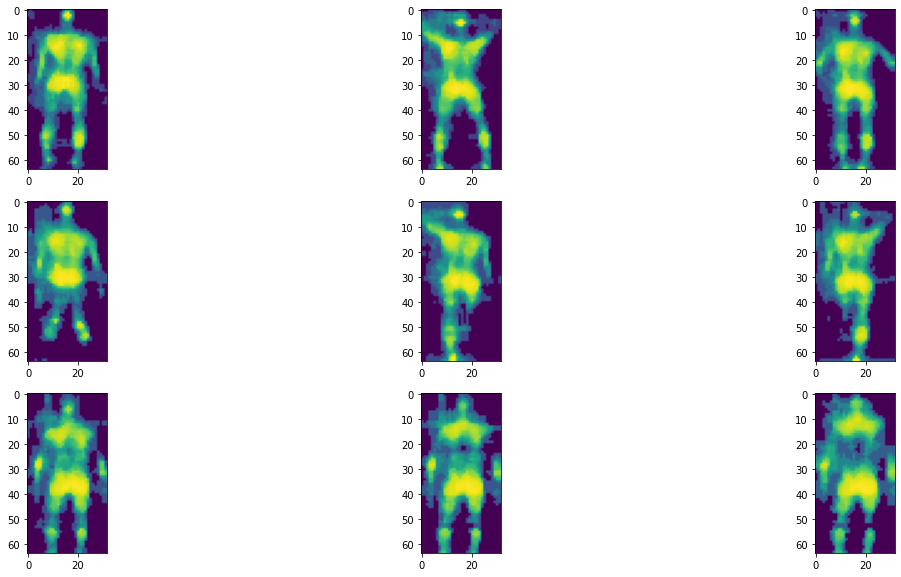

In [37]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(3,3,1)
plt.imshow(train_data.samples[train_data.labels == 0][0])
fig.add_subplot(3,3,2)
plt.imshow(train_data.samples[train_data.labels == 1][0])
fig.add_subplot(3,3,3)
plt.imshow(train_data.samples[train_data.labels == 2][0])
fig.add_subplot(3,3,4)
plt.imshow(train_data.samples[train_data.labels == 3][0])
fig.add_subplot(3,3,5)
plt.imshow(train_data.samples[train_data.labels == 4][0])
fig.add_subplot(3,3,6)
plt.imshow(train_data.samples[train_data.labels == 5][0])
fig.add_subplot(3,3,7)
plt.imshow(train_data.samples[train_data.labels == 6][0])
fig.add_subplot(3,3,8)
plt.imshow(train_data.samples[train_data.labels == 7][0])
fig.add_subplot(3,3,9)
plt.imshow(train_data.samples[train_data.labels == 8][0])

In [12]:
x_train = []

for i in range(len(train_data.samples)):
    
    train_data.samples[i] = cv2.equalizeHist(train_data.samples[i])

    heat = cv2.applyColorMap(train_data.samples[i], cv2.COLORMAP_JET)
    mask = np.ones_like(heat)
    bin1 = np.array(heat>=mask*63).astype(np.uint8)
    bin2 = np.array(heat>=mask*127).astype(np.uint8)
    bin3 = np.array(heat>=mask*190).astype(np.uint8)
    bin_out = np.concatenate((bin1,bin2,bin3),axis=2)

    x_train.append(bin_out)

x_test = []

for i in range(len(test_data.samples)):

    test_data.samples[i] = cv2.equalizeHist(test_data.samples[i])
    
    heat = cv2.applyColorMap(test_data.samples[i], cv2.COLORMAP_JET)
    mask = np.ones_like(heat)
    bin1 = np.array(heat>=mask*63).astype(np.uint8)
    bin2 = np.array(heat>=mask*127).astype(np.uint8)
    bin3 = np.array(heat>=mask*190).astype(np.uint8)
    bin_out = np.concatenate((bin1,bin2,bin3),axis=2)

    x_test.append(bin_out)

In [13]:
x_train = np.array(x_train).astype(np.uint8)
x_test = np.array(x_test).astype(np.uint8)

In [14]:
print(x_test.shape)
print(x_train.shape)
print(x_train[0].shape)

(553, 64, 32, 9)
(8656, 64, 32, 9)
(64, 32, 9)


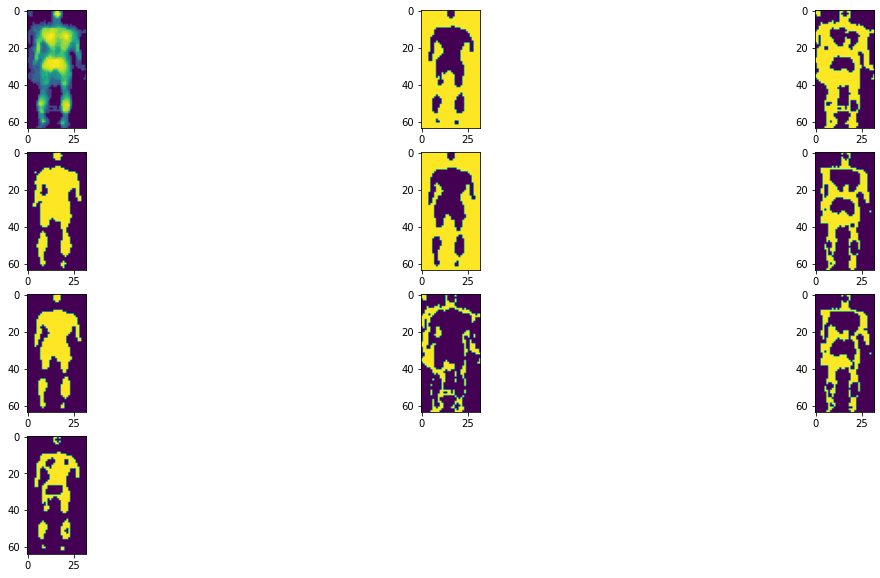

In [40]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(4,3,1)
plt.imshow(train_data.samples[0])
fig.add_subplot(4,3,2)
plt.imshow(x_train[0][:,:,0])
fig.add_subplot(4,3,3)
plt.imshow(x_train[0][:,:,1])
fig.add_subplot(4,3,4)
plt.imshow(x_train[0][:,:,2])
fig.add_subplot(4,3,5)
plt.imshow(x_train[0][:,:,3])
fig.add_subplot(4,3,6)
plt.imshow(x_train[0][:,:,4])
fig.add_subplot(4,3,7)
plt.imshow(x_train[0][:,:,5])
fig.add_subplot(4,3,8)
plt.imshow(x_train[0][:,:,6])
fig.add_subplot(4,3,9)
plt.imshow(x_train[0][:,:,7])
fig.add_subplot(4,3,10)
plt.imshow(x_train[0][:,:,8])

In [21]:
inputs = Input(shape=(64, 32, 9))

flattened = Flatten()(inputs)

# flattened_inputs_1 = Lambda(lambda x : x[:,      :2048*3 ])(flattened)
# flattened_inputs_2 = Lambda(lambda x : x[:,2048*3:2048*6])(flattened)
# flattened_inputs_3 = Lambda(lambda x : x[:,2048*6: ])(flattened)

# R_1 = Lambda(lambda x : x[:,     :2048 ])(flattened_inputs_1)
# G_1 = Lambda(lambda x : x[:, 2048:4096 ])(flattened_inputs_1)
# B_1 = Lambda(lambda x : x[:, 4096:     ])(flattened_inputs_1)

# R_2 = Lambda(lambda x : x[:,     :2048 ])(flattened_inputs_2)
# G_2 = Lambda(lambda x : x[:, 2048:4096 ])(flattened_inputs_2)
# B_2 = Lambda(lambda x : x[:, 4096:     ])(flattened_inputs_2)

# R_3 = Lambda(lambda x : x[:,     :2048 ])(flattened_inputs_3)
# G_3 = Lambda(lambda x : x[:, 2048:4096 ])(flattened_inputs_3)
# B_3 = Lambda(lambda x : x[:, 4096:     ])(flattened_inputs_3)

# Init 21 cores

tea_0_1 = Tea(64)
tea_0_2 = Tea(64)
tea_0_3 = Tea(64)
tea_0_4 = Tea(64)
tea_0_5 = Tea(64)
tea_0_6 = Tea(64)
tea_0_7 = Tea(64)
tea_0_8 = Tea(64)
tea_0_9 = Tea(64)
tea_0_10 = Tea(64)
tea_0_11 = Tea(64)
tea_0_12 = Tea(64)
tea_0_13 = Tea(64)
tea_0_14 = Tea(64)
tea_0_15 = Tea(64)
tea_0_16 = Tea(64)

tea_1_1 = Tea(64)
tea_1_2 = Tea(64)
tea_1_3 = Tea(64)
tea_1_4 = Tea(64)

tea_2_1 = Tea(252)

R_1 = Lambda(lambda x : x[:,     :1*2048 ])(flattened)
G_1 = Lambda(lambda x : x[:, 1*2048:2*2048])(flattened)
B_1 = Lambda(lambda x : x[:, 2*2048:3*2048])(flattened)

R_2 = Lambda(lambda x : x[:, 3*2048:4*2048 ])(flattened)
G_2 = Lambda(lambda x : x[:, 4*2048:5*2048 ])(flattened)
B_2 = Lambda(lambda x : x[:, 5*2048:6*2048 ])(flattened)

R_3 = Lambda(lambda x : x[:, 6*2048:7*2048])(flattened)
G_3 = Lambda(lambda x : x[:, 7*2048:8*2048])(flattened)
B_3 = Lambda(lambda x : x[:, 8*2048:9*2048])(flattened)

x1_1  = Lambda(lambda x : x[:,     :256 ])(R_1)
x2_1  = Lambda(lambda x : x[:, 119 : 375 ])(R_1)
x3_1  = Lambda(lambda x : x[:, 238 :494 ])(R_1)
x4_1  = Lambda(lambda x : x[:, 357 : 613])(R_1)
x5_1  = Lambda(lambda x : x[:, 476:732])(R_1)
x6_1  = Lambda(lambda x : x[:, 595:851])(R_1)
x7_1  = Lambda(lambda x : x[:, 714:970])(R_1)
x8_1  = Lambda(lambda x : x[:, 833:1089])(R_1)
x9_1  = Lambda(lambda x : x[:, 952:1208])(R_1)
x10_1  = Lambda(lambda x : x[:, 1071:1327])(R_1)
x11_1  = Lambda(lambda x : x[:, 1190:1446])(R_1)
x12_1  = Lambda(lambda x : x[:, 1309:1565])(R_1)
x13_1  = Lambda(lambda x : x[:, 1428:1684])(R_1)
x14_1  = Lambda(lambda x : x[:, 1547:1803])(R_1)
x15_1  = Lambda(lambda x : x[:, 1666:1922])(R_1)
x16_1  = Lambda(lambda x : x[:, 1785:2041])(R_1)

x1_1  = tea_0_1(x1_1)
x2_1  = tea_0_2(x2_1)
x3_1  = tea_0_3(x3_1)
x4_1  = tea_0_4(x4_1)
x5_1  = tea_0_5(x5_1)
x6_1  = tea_0_6(x6_1)
x7_1  = tea_0_7(x7_1)
x8_1  = tea_0_8(x8_1)
x9_1  = tea_0_9(x9_1)
x10_1  = tea_0_10(x10_1)
x11_1  = tea_0_11(x11_1)
x12_1  = tea_0_12(x12_1)
x13_1  = tea_0_13(x13_1)
x14_1  = tea_0_14(x14_1)
x15_1  = tea_0_15(x15_1)
x16_1  = tea_0_16(x16_1)

x1_2  = Lambda(lambda x : x[:,     :256 ])(G_1)
x2_2  = Lambda(lambda x : x[:, 119 : 375 ])(G_1)
x3_2  = Lambda(lambda x : x[:, 238 :494 ])(G_1)
x4_2  = Lambda(lambda x : x[:, 357 : 613])(G_1)
x5_2  = Lambda(lambda x : x[:, 476:732])(G_1)
x6_2  = Lambda(lambda x : x[:, 595:851])(G_1)
x7_2  = Lambda(lambda x : x[:, 714:970])(G_1)
x8_2  = Lambda(lambda x : x[:, 833:1089])(G_1)
x9_2  = Lambda(lambda x : x[:, 952:1208])(G_1)
x10_2  = Lambda(lambda x : x[:, 1071:1327])(G_1)
x11_2  = Lambda(lambda x : x[:, 1190:1446])(G_1)
x12_2  = Lambda(lambda x : x[:, 1309:1565])(G_1)
x13_2  = Lambda(lambda x : x[:, 1428:1684])(G_1)
x14_2  = Lambda(lambda x : x[:, 1547:1803])(G_1)
x15_2  = Lambda(lambda x : x[:, 1666:1922])(G_1)
x16_2  = Lambda(lambda x : x[:, 1785:2041])(G_1)

x1_2  = tea_0_1(x1_2)
x2_2  = tea_0_2(x2_2)
x3_2  = tea_0_3(x3_2)
x4_2  = tea_0_4(x4_2)
x5_2  = tea_0_5(x5_2)
x6_2  = tea_0_6(x6_2)
x7_2  = tea_0_7(x7_2)
x8_2  = tea_0_8(x8_2)
x9_2  = tea_0_9(x9_2)
x10_2  = tea_0_10(x10_2)
x11_2  = tea_0_11(x11_2)
x12_2  = tea_0_12(x12_2)
x13_2  = tea_0_13(x13_2)
x14_2  = tea_0_14(x14_2)
x15_2  = tea_0_15(x15_2)
x16_2  = tea_0_16(x16_2)

x1_3  = Lambda(lambda x : x[:,     :256 ])(B_1)
x2_3  = Lambda(lambda x : x[:, 119 : 375 ])(B_1)
x3_3  = Lambda(lambda x : x[:, 238 :494 ])(B_1)
x4_3  = Lambda(lambda x : x[:, 357 : 613])(B_1)
x5_3  = Lambda(lambda x : x[:, 476:732])(B_1)
x6_3  = Lambda(lambda x : x[:, 595:851])(B_1)
x7_3  = Lambda(lambda x : x[:, 714:970])(B_1)
x8_3  = Lambda(lambda x : x[:, 833:1089])(B_1)
x9_3  = Lambda(lambda x : x[:, 952:1208])(B_1)
x10_3  = Lambda(lambda x : x[:, 1071:1327])(B_1)
x11_3  = Lambda(lambda x : x[:, 1190:1446])(B_1)
x12_3  = Lambda(lambda x : x[:, 1309:1565])(B_1)
x13_3  = Lambda(lambda x : x[:, 1428:1684])(B_1)
x14_3  = Lambda(lambda x : x[:, 1547:1803])(B_1)
x15_3  = Lambda(lambda x : x[:, 1666:1922])(B_1)
x16_3  = Lambda(lambda x : x[:, 1785:2041])(B_1)

x1_3  = tea_0_1(x1_3)
x2_3  = tea_0_2(x2_3)
x3_3  = tea_0_3(x3_3)
x4_3  = tea_0_4(x4_3)
x5_3  = tea_0_5(x5_3)
x6_3  = tea_0_6(x6_3)
x7_3  = tea_0_7(x7_3)
x8_3  = tea_0_8(x8_3)
x9_3  = tea_0_9(x9_3)
x10_3  = tea_0_10(x10_3)
x11_3  = tea_0_11(x11_3)
x12_3  = tea_0_12(x12_3)
x13_3  = tea_0_13(x13_3)
x14_3  = tea_0_14(x14_3)
x15_3  = tea_0_15(x15_3)
x16_3  = tea_0_16(x16_3)

### 2 ###

x1_4  = Lambda(lambda x : x[:,     :256 ])(R_2)
x2_4  = Lambda(lambda x : x[:, 119 : 375 ])(R_2)
x3_4  = Lambda(lambda x : x[:, 238 :494 ])(R_2)
x4_4  = Lambda(lambda x : x[:, 357 : 613])(R_2)
x5_4  = Lambda(lambda x : x[:, 476:732])(R_2)
x6_4  = Lambda(lambda x : x[:, 595:851])(R_2)
x7_4  = Lambda(lambda x : x[:, 714:970])(R_2)
x8_4  = Lambda(lambda x : x[:, 833:1089])(R_2)
x9_4  = Lambda(lambda x : x[:, 952:1208])(R_2)
x10_4  = Lambda(lambda x : x[:, 1071:1327])(R_2)
x11_4  = Lambda(lambda x : x[:, 1190:1446])(R_2)
x12_4  = Lambda(lambda x : x[:, 1309:1565])(R_2)
x13_4  = Lambda(lambda x : x[:, 1428:1684])(R_2)
x14_4  = Lambda(lambda x : x[:, 1547:1803])(R_2)
x15_4  = Lambda(lambda x : x[:, 1666:1922])(R_2)
x16_4  = Lambda(lambda x : x[:, 1785:2041])(R_2)

x1_4  = tea_0_1(x1_4)
x2_4  = tea_0_2(x2_4)
x3_4  = tea_0_3(x3_4)
x4_4  = tea_0_4(x4_4)
x5_4  = tea_0_5(x5_4)
x6_4  = tea_0_6(x6_4)
x7_4  = tea_0_7(x7_4)
x8_4  = tea_0_8(x8_4)
x9_4  = tea_0_9(x9_4)
x10_4  = tea_0_10(x10_4)
x11_4  = tea_0_11(x11_4)
x12_4  = tea_0_12(x12_4)
x13_4  = tea_0_13(x13_4)
x14_4  = tea_0_14(x14_4)
x15_4  = tea_0_15(x15_4)
x16_4  = tea_0_16(x16_4)

x1_5  = Lambda(lambda x : x[:,     :256 ])(G_2)
x2_5  = Lambda(lambda x : x[:, 119 : 375 ])(G_2)
x3_5  = Lambda(lambda x : x[:, 238 :494 ])(G_2)
x4_5  = Lambda(lambda x : x[:, 357 : 613])(G_2)
x5_5  = Lambda(lambda x : x[:, 476:732])(G_2)
x6_5  = Lambda(lambda x : x[:, 595:851])(G_2)
x7_5  = Lambda(lambda x : x[:, 714:970])(G_2)
x8_5  = Lambda(lambda x : x[:, 833:1089])(G_2)
x9_5  = Lambda(lambda x : x[:, 952:1208])(G_2)
x10_5  = Lambda(lambda x : x[:, 1071:1327])(G_2)
x11_5  = Lambda(lambda x : x[:, 1190:1446])(G_2)
x12_5  = Lambda(lambda x : x[:, 1309:1565])(G_2)
x13_5  = Lambda(lambda x : x[:, 1428:1684])(G_2)
x14_5  = Lambda(lambda x : x[:, 1547:1803])(G_2)
x15_5  = Lambda(lambda x : x[:, 1666:1922])(G_2)
x16_5  = Lambda(lambda x : x[:, 1785:2041])(G_2)

x1_5  = tea_0_1(x1_5)
x2_5  = tea_0_2(x2_5)
x3_5  = tea_0_3(x3_5)
x4_5  = tea_0_4(x4_5)
x5_5  = tea_0_5(x5_5)
x6_5  = tea_0_6(x6_5)
x7_5  = tea_0_7(x7_5)
x8_5  = tea_0_8(x8_5)
x9_5  = tea_0_9(x9_5)
x10_5  = tea_0_10(x10_5)
x11_5  = tea_0_11(x11_5)
x12_5  = tea_0_12(x12_5)
x13_5  = tea_0_13(x13_5)
x14_5  = tea_0_14(x14_5)
x15_5  = tea_0_15(x15_5)
x16_5  = tea_0_16(x16_5)

x1_6  = Lambda(lambda x : x[:,     :256 ])(B_2)
x2_6  = Lambda(lambda x : x[:, 119 : 375 ])(B_2)
x3_6  = Lambda(lambda x : x[:, 238 :494 ])(B_2)
x4_6  = Lambda(lambda x : x[:, 357 : 613])(B_2)
x5_6  = Lambda(lambda x : x[:, 476:732])(B_2)
x6_6  = Lambda(lambda x : x[:, 595:851])(B_2)
x7_6  = Lambda(lambda x : x[:, 714:970])(B_2)
x8_6  = Lambda(lambda x : x[:, 833:1089])(B_2)
x9_6  = Lambda(lambda x : x[:, 952:1208])(B_2)
x10_6  = Lambda(lambda x : x[:, 1071:1327])(B_2)
x11_6  = Lambda(lambda x : x[:, 1190:1446])(B_2)
x12_6  = Lambda(lambda x : x[:, 1309:1565])(B_2)
x13_6  = Lambda(lambda x : x[:, 1428:1684])(B_2)
x14_6  = Lambda(lambda x : x[:, 1547:1803])(B_2)
x15_6  = Lambda(lambda x : x[:, 1666:1922])(B_2)
x16_6  = Lambda(lambda x : x[:, 1785:2041])(B_2)

x1_6  = tea_0_1(x1_6)
x2_6  = tea_0_2(x2_6)
x3_6  = tea_0_3(x3_6)
x4_6  = tea_0_4(x4_6)
x5_6  = tea_0_5(x5_6)
x6_6  = tea_0_6(x6_6)
x7_6  = tea_0_7(x7_6)
x8_6  = tea_0_8(x8_6)
x9_6  = tea_0_9(x9_6)
x10_6  = tea_0_10(x10_6)
x11_6  = tea_0_11(x11_6)
x12_6  = tea_0_12(x12_6)
x13_6  = tea_0_13(x13_6)
x14_6  = tea_0_14(x14_6)
x15_6  = tea_0_15(x15_6)
x16_6  = tea_0_16(x16_6)

### 3 ###

x1_7  = Lambda(lambda x : x[:,     :256 ])(R_3)
x2_7  = Lambda(lambda x : x[:, 119 : 375 ])(R_3)
x3_7  = Lambda(lambda x : x[:, 238 :494 ])(R_3)
x4_7  = Lambda(lambda x : x[:, 357 : 613])(R_3)
x5_7  = Lambda(lambda x : x[:, 476:732])(R_3)
x6_7  = Lambda(lambda x : x[:, 595:851])(R_3)
x7_7  = Lambda(lambda x : x[:, 714:970])(R_3)
x8_7  = Lambda(lambda x : x[:, 833:1089])(R_3)
x9_7  = Lambda(lambda x : x[:, 952:1208])(R_3)
x10_7  = Lambda(lambda x : x[:, 1071:1327])(R_3)
x11_7  = Lambda(lambda x : x[:, 1190:1446])(R_3)
x12_7  = Lambda(lambda x : x[:, 1309:1565])(R_3)
x13_7  = Lambda(lambda x : x[:, 1428:1684])(R_3)
x14_7  = Lambda(lambda x : x[:, 1547:1803])(R_3)
x15_7  = Lambda(lambda x : x[:, 1666:1922])(R_3)
x16_7  = Lambda(lambda x : x[:, 1785:2041])(R_3)

x1_7  = tea_0_1(x1_7)
x2_7  = tea_0_2(x2_7)
x3_7  = tea_0_3(x3_7)
x4_7  = tea_0_4(x4_7)
x5_7  = tea_0_5(x5_7)
x6_7  = tea_0_6(x6_7)
x7_7  = tea_0_7(x7_7)
x8_7  = tea_0_8(x8_7)
x9_7  = tea_0_9(x9_7)
x10_7  = tea_0_10(x10_7)
x11_7  = tea_0_11(x11_7)
x12_7  = tea_0_12(x12_7)
x13_7  = tea_0_13(x13_7)
x14_7  = tea_0_14(x14_7)
x15_7  = tea_0_15(x15_7)
x16_7  = tea_0_16(x16_7)

x1_8  = Lambda(lambda x : x[:,     :256 ])(G_3)
x2_8  = Lambda(lambda x : x[:, 119 : 375 ])(G_3)
x3_8  = Lambda(lambda x : x[:, 238 :494 ])(G_3)
x4_8  = Lambda(lambda x : x[:, 357 : 613])(G_3)
x5_8  = Lambda(lambda x : x[:, 476:732])(G_3)
x6_8  = Lambda(lambda x : x[:, 595:851])(G_3)
x7_8  = Lambda(lambda x : x[:, 714:970])(G_3)
x8_8  = Lambda(lambda x : x[:, 833:1089])(G_3)
x9_8  = Lambda(lambda x : x[:, 952:1208])(G_3)
x10_8  = Lambda(lambda x : x[:, 1071:1327])(G_3)
x11_8  = Lambda(lambda x : x[:, 1190:1446])(G_3)
x12_8  = Lambda(lambda x : x[:, 1309:1565])(G_3)
x13_8  = Lambda(lambda x : x[:, 1428:1684])(G_3)
x14_8  = Lambda(lambda x : x[:, 1547:1803])(G_3)
x15_8  = Lambda(lambda x : x[:, 1666:1922])(G_3)
x16_8  = Lambda(lambda x : x[:, 1785:2041])(G_3)

x1_8  = tea_0_1(x1_8)
x2_8  = tea_0_2(x2_8)
x3_8  = tea_0_3(x3_8)
x4_8  = tea_0_4(x4_8)
x5_8  = tea_0_5(x5_8)
x6_8  = tea_0_6(x6_8)
x7_8  = tea_0_7(x7_8)
x8_8  = tea_0_8(x8_8)
x9_8  = tea_0_9(x9_8)
x10_8  = tea_0_10(x10_8)
x11_8  = tea_0_11(x11_8)
x12_8  = tea_0_12(x12_8)
x13_8  = tea_0_13(x13_8)
x14_8  = tea_0_14(x14_8)
x15_8  = tea_0_15(x15_8)
x16_8  = tea_0_16(x16_8)

x1_9  = Lambda(lambda x : x[:,     :256 ])(B_3)
x2_9  = Lambda(lambda x : x[:, 119 : 375 ])(B_3)
x3_9  = Lambda(lambda x : x[:, 238 :494 ])(B_3)
x4_9  = Lambda(lambda x : x[:, 357 : 613])(B_3)
x5_9  = Lambda(lambda x : x[:, 476:732])(B_3)
x6_9  = Lambda(lambda x : x[:, 595:851])(B_3)
x7_9  = Lambda(lambda x : x[:, 714:970])(B_3)
x8_9  = Lambda(lambda x : x[:, 833:1089])(B_3)
x9_9  = Lambda(lambda x : x[:, 952:1208])(B_3)
x10_9  = Lambda(lambda x : x[:, 1071:1327])(B_3)
x11_9  = Lambda(lambda x : x[:, 1190:1446])(B_3)
x12_9  = Lambda(lambda x : x[:, 1309:1565])(B_3)
x13_9  = Lambda(lambda x : x[:, 1428:1684])(B_3)
x14_9  = Lambda(lambda x : x[:, 1547:1803])(B_3)
x15_9  = Lambda(lambda x : x[:, 1666:1922])(B_3)
x16_9  = Lambda(lambda x : x[:, 1785:2041])(B_3)

x1_9  = tea_0_1(x1_9)
x2_9  = tea_0_2(x2_9)
x3_9  = tea_0_3(x3_9)
x4_9  = tea_0_4(x4_9)
x5_9  = tea_0_5(x5_9)
x6_9  = tea_0_6(x6_9)
x7_9  = tea_0_7(x7_9)
x8_9  = tea_0_8(x8_9)
x9_9  = tea_0_9(x9_9)
x10_9  = tea_0_10(x10_9)
x11_9  = tea_0_11(x11_9)
x12_9  = tea_0_12(x12_9)
x13_9  = tea_0_13(x13_9)
x14_9  = tea_0_14(x14_9)
x15_9  = tea_0_15(x15_9)
x16_9  = tea_0_16(x16_9)


In [17]:
#Average 1->5
x1_1_1 = Average()([x1_1,x1_2,x1_3,x1_4,x1_5])
x2_1_1 = Average()([x2_1,x2_2,x2_3,x2_4,x2_5])
x3_1_1 = Average()([x3_1,x3_2,x3_3,x3_4,x3_5])
x4_1_1 = Average()([x4_1,x4_2,x4_3,x4_4,x4_5])
x5_1_1 = Average()([x5_1,x5_2,x5_3,x5_4,x5_5])
x6_1_1 = Average()([x6_1,x6_2,x6_3,x6_4,x6_5])
x7_1_1 = Average()([x7_1,x7_2,x7_3,x7_4,x7_5])
x8_1_1 = Average()([x8_1,x8_2,x8_3,x8_4,x8_5])
x9_1_1 = Average()([x9_1,x9_2,x9_3,x9_4,x9_5])
x10_1_1 = Average()([x10_1,x10_2,x10_3,x10_4,x10_5])
x11_1_1 = Average()([x11_1,x11_2,x11_3,x11_4,x11_5])
x12_1_1 = Average()([x12_1,x12_2,x12_3,x12_4,x12_5])
x13_1_1 = Average()([x13_1,x13_2,x13_3,x13_4,x13_5])
x14_1_1 = Average()([x14_1,x14_2,x14_3,x14_4,x14_5])
x15_1_1 = Average()([x15_1,x15_2,x15_3,x15_4,x15_5])
x16_1_1 = Average()([x16_1,x16_2,x16_3,x16_4,x16_5])

#Average image 2->6

x1_1_2 = Average()([x1_2,x1_3,x1_4,x1_5,x1_6])
x2_1_2 = Average()([x2_2,x2_3,x2_4,x2_5,x2_6])
x3_1_2 = Average()([x3_2,x3_3,x3_4,x3_5,x3_6])
x4_1_2 = Average()([x4_2,x4_3,x4_4,x4_5,x4_6])
x5_1_2 = Average()([x5_2,x5_3,x5_4,x5_5,x5_6])
x6_1_2 = Average()([x6_2,x6_3,x6_4,x6_5,x6_6])
x7_1_2 = Average()([x7_2,x7_3,x7_4,x7_5,x7_6])
x8_1_2 = Average()([x8_2,x8_3,x8_4,x8_5,x8_6])
x9_1_2 = Average()([x9_2,x9_3,x9_4,x9_5,x9_6])
x10_1_2 = Average()([x10_2,x10_3,x10_4,x10_5,x10_6])
x11_1_2 = Average()([x11_2,x11_3,x11_4,x11_5,x11_6])
x12_1_2 = Average()([x12_2,x12_3,x12_4,x12_5,x12_6])
x13_1_2 = Average()([x13_2,x13_3,x13_4,x13_5,x13_6])
x14_1_2 = Average()([x14_2,x14_3,x14_4,x14_5,x14_6])
x15_1_2 = Average()([x15_2,x15_3,x15_4,x15_5,x15_6])
x16_1_2 = Average()([x16_2,x16_3,x16_4,x16_5,x16_6])

#Average image 3->7

x1_1_3 = Average()([x1_3,x1_4,x1_5,x1_6,x1_7])
x2_1_3 = Average()([x2_3,x2_4,x2_5,x2_6,x2_7])
x3_1_3 = Average()([x3_3,x3_4,x3_5,x3_6,x3_7])
x4_1_3 = Average()([x4_3,x4_4,x4_5,x4_6,x4_7])
x5_1_3 = Average()([x5_3,x5_4,x5_5,x5_6,x5_7])
x6_1_3 = Average()([x6_3,x6_4,x6_5,x6_6,x6_7])
x7_1_3 = Average()([x7_3,x7_4,x7_5,x7_6,x7_7])
x8_1_3 = Average()([x8_3,x8_4,x8_5,x8_6,x8_7])
x9_1_3 = Average()([x9_3,x9_4,x9_5,x9_6,x9_7])
x10_1_3 = Average()([x10_3,x10_4,x10_5,x10_6,x10_7])
x11_1_3 = Average()([x11_3,x11_4,x11_5,x11_6,x11_7])
x12_1_3 = Average()([x12_3,x12_4,x12_5,x12_6,x12_7])
x13_1_3 = Average()([x13_3,x13_4,x13_5,x13_6,x13_7])
x14_1_3 = Average()([x14_3,x14_4,x14_5,x14_6,x14_7])
x15_1_3 = Average()([x15_3,x15_4,x15_5,x15_6,x15_7])
x16_1_3 = Average()([x16_3,x16_4,x16_5,x16_6,x16_7])

#Average image 4->8

x1_1_4 = Average()([x1_4,x1_5,x1_6,x1_7,x1_8])
x2_1_4 = Average()([x2_4,x2_5,x2_6,x2_7,x2_8])
x3_1_4 = Average()([x3_4,x3_5,x3_6,x3_7,x3_8])
x4_1_4 = Average()([x4_4,x4_5,x4_6,x4_7,x4_8])
x5_1_4 = Average()([x5_4,x5_5,x5_6,x5_7,x5_8])
x6_1_4 = Average()([x6_4,x6_5,x6_6,x6_7,x6_8])
x7_1_4 = Average()([x7_4,x7_5,x7_6,x7_7,x7_8])
x8_1_4 = Average()([x8_4,x8_5,x8_6,x8_7,x8_8])
x9_1_4 = Average()([x9_4,x9_5,x9_6,x9_7,x9_8])
x10_1_4 = Average()([x10_4,x10_5,x10_6,x10_7,x10_8])
x11_1_4 = Average()([x11_4,x11_5,x11_6,x11_7,x11_8])
x12_1_4 = Average()([x12_4,x12_5,x12_6,x12_7,x12_8])
x13_1_4 = Average()([x13_4,x13_5,x13_6,x13_7,x13_8])
x14_1_4 = Average()([x14_4,x14_5,x14_6,x14_7,x14_8])
x15_1_4 = Average()([x15_4,x15_5,x15_6,x15_7,x15_8])
x16_1_4 = Average()([x16_4,x16_5,x16_6,x16_7,x16_8])

#Average image 5->9

x1_1_5 = Average()([x1_5,x1_6,x1_7,x1_8,x1_9])
x2_1_5 = Average()([x2_5,x2_6,x2_7,x2_8,x2_9])
x3_1_5 = Average()([x3_5,x3_6,x3_7,x3_8,x3_9])
x4_1_5 = Average()([x4_5,x4_6,x4_7,x4_8,x4_9])
x5_1_5 = Average()([x5_5,x5_6,x5_7,x5_8,x5_9])
x6_1_5 = Average()([x6_5,x6_6,x6_7,x6_8,x6_9])
x7_1_5 = Average()([x7_5,x7_6,x7_7,x7_8,x7_9])
x8_1_5 = Average()([x8_5,x8_6,x8_7,x8_8,x8_9])
x9_1_5 = Average()([x9_5,x9_6,x9_7,x9_6,x9_9])
x10_1_5 = Average()([x10_5,x10_6,x10_7,x10_8,x10_9])
x11_1_5 = Average()([x11_5,x11_6,x11_7,x11_8,x11_9])
x12_1_5 = Average()([x12_5,x12_6,x12_7,x12_8,x12_9])
x13_1_5 = Average()([x13_5,x13_6,x13_7,x13_8,x13_9])
x14_1_5 = Average()([x14_5,x14_6,x14_7,x14_8,x14_9])
x15_1_5 = Average()([x15_5,x15_6,x15_7,x15_8,x15_9])
x16_1_5 = Average()([x16_5,x16_6,x16_7,x16_8,x16_9])

In [18]:
x1_1 = concatenate(([x1_1_1,x2_1_1,x3_1_1,x4_1_1]),axis=1)
x2_1 = concatenate(([x5_1_1,x6_1_1,x7_1_1,x8_1_1]),axis=1)
x3_1 = concatenate(([x9_1_1,x10_1_1,x11_1_1,x12_1_1]),axis=1)
x4_1 = concatenate(([x13_1_1,x14_1_1,x15_1_1,x16_1_1]),axis=1)

x1_2 = concatenate(([x1_1_2,x2_1_2,x3_1_2,x4_1_2]),axis=1)
x2_2 = concatenate(([x5_1_2,x6_1_2,x7_1_2,x8_1_2]),axis=1)
x3_2 = concatenate(([x9_1_2,x10_1_2,x11_1_2,x12_1_2]),axis=1)
x4_2 = concatenate(([x13_1_2,x14_1_2,x15_1_2,x16_1_2]),axis=1)

x1_3 = concatenate(([x1_1_3,x2_1_3,x3_1_3,x4_1_3]),axis=1)
x2_3 = concatenate(([x5_1_3,x6_1_3,x7_1_3,x8_1_3]),axis=1)
x3_3 = concatenate(([x9_1_3,x10_1_3,x11_1_3,x12_1_3]),axis=1)
x4_3 = concatenate(([x13_1_3,x14_1_3,x15_1_3,x16_1_3]),axis=1)

x1_4 = concatenate(([x1_1_4,x2_1_4,x3_1_4,x4_1_4]),axis=1)
x2_4 = concatenate(([x5_1_4,x6_1_4,x7_1_4,x8_1_4]),axis=1)
x3_4 = concatenate(([x9_1_4,x10_1_4,x11_1_4,x12_1_4]),axis=1)
x4_4 = concatenate(([x13_1_4,x14_1_4,x15_1_4,x16_1_4]),axis=1)

x1_5 = concatenate(([x1_1_5,x2_1_5,x3_1_5,x4_1_5]),axis=1)
x2_5 = concatenate(([x5_1_5,x6_1_5,x7_1_5,x8_1_5]),axis=1)
x3_5 = concatenate(([x9_1_5,x10_1_5,x11_1_5,x12_1_5]),axis=1)
x4_5 = concatenate(([x13_1_5,x14_1_5,x15_1_5,x16_1_5]),axis=1)

x1_1 = tea_1_1(x1_1)
x2_1 = tea_1_2(x2_1)
x3_1 = tea_1_3(x3_1)
x4_1 = tea_1_4(x4_1)

x1_2 = tea_1_1(x1_2)
x2_2 = tea_1_2(x2_2)
x3_2 = tea_1_3(x3_2)
x4_2 = tea_1_4(x4_2)

x1_3 = tea_1_1(x1_3)
x2_3 = tea_1_2(x2_3)
x3_3 = tea_1_3(x3_3)
x4_3 = tea_1_4(x4_3)

x1_4 = tea_1_1(x1_4)
x2_4 = tea_1_2(x2_4)
x3_4 = tea_1_3(x3_4)
x4_4 = tea_1_4(x4_4)

x1_5 = tea_1_1(x1_5)
x2_5 = tea_1_2(x2_5)
x3_5 = tea_1_3(x3_5)
x4_5 = tea_1_4(x4_5)

In [26]:
#Average after layer 2
x_out_1 = Average()([x1_1,x1_2,x1_3,x1_4,x1_5])
x_out_2 = Average()([x2_1,x2_2,x2_3,x2_4,x2_5])
x_out_3 = Average()([x3_1,x3_2,x3_3,x3_4,x3_5])
x_out_4 = Average()([x4_1,x4_2,x4_3,x4_4,x4_5])

# Layer 3

x_out = concatenate(([x_out_1,x_out_2,x_out_3,x_out_4]),axis=1)

x_out = tea_2_1(x_out) # 252 divided by 9

x_out = AdditivePooling(9)(x_out)

predictions = Activation('softmax')(x_out)


In [27]:
  #Model

model = Model(inputs=inputs, outputs=predictions)

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.0001),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=70,
          verbose=1,
          validation_split=0.2)

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Train on 6924 samples, validate on 1732 samples
Epoch 1/70
6656/6924 [===========================>..] - ETA: 0s - loss: 2.3114 - acc: 0.1484

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


6924/6924 [==============================] - 3s 400us/sample - loss: 2.3034 - acc: 0.1489 - val_loss: 2.2486 - val_acc: 0.1149
Epoch 2/70
6924/6924 [==============================] - 1s 183us/sample - loss: 1.8483 - acc: 0.3146 - val_loss: 2.1404 - val_acc: 0.2373
Epoch 3/70
6924/6924 [==============================] - 1s 186us/sample - loss: 1.1208 - acc: 0.6811 - val_loss: 1.8819 - val_acc: 0.3533
Epoch 4/70
6924/6924 [==============================] - 1s 178us/sample - loss: 0.6428 - acc: 0.8400 - val_loss: 1.6902 - val_acc: 0.4249
Epoch 5/70
6924/6924 [==============================] - 1s 182us/sample - loss: 0.3996 - acc: 0.9168 - val_loss: 1.7155 - val_acc: 0.4538
Epoch 6/70
6924/6924 [==============================] - 1s 180us/sample - loss: 0.2659 - acc: 0.9549 - val_loss: 1.8977 - val_acc: 0.4192
Epoch 7/70
6924/6924 [==============================] - 1s 173us/sample - loss: 0.1883 - acc: 0.9727 - val_loss: 1.7073 - val_acc: 0.4573
Epoch 8/70
6924/6924 [=======================